In [10]:
import sys
import os
import pandas as pd
from great_tables import GT

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), '..')))

from AzureBlobLoader import AzureBlobLoader
from DataTransformer import DataTransformer
from utils.config import CONFIG, CONN_STRING_AZURE_STORAGE

def load_data():
    try:
        loader = AzureBlobLoader(CONFIG, CONN_STRING_AZURE_STORAGE)
        dataframes = loader.load_dataframes()
        print("Data loaded successfully!")
        return dataframes
    except Exception as e:
        print(f"Error loading data: {e}", exc_info=True)

In [11]:
dataframes = load_data()

Successfully read blob from gold/epl_news/dim_date.parquet
Successfully read blob from gold/epl_news/article.parquet
Successfully read blob from gold/epl_news/dim_team.parquet
Successfully read blob from gold/epl_news/reaction.parquet
Successfully read blob from gold/epl_news/dim_sentiment.parquet
Successfully read blob from gold/epl_news/fact_reaction.parquet
Successfully read blob from gold/epl_news/fact_title.parquet
Data loaded successfully!


In [12]:
df_date = dataframes['df_date']
df_article = dataframes['df_article']
df_team = dataframes['df_team']
df_sentiment = dataframes['df_sentiment']
df_fact_reaction = dataframes['df_fact_reaction']
df_fact_title = dataframes['df_fact_title']

In [13]:
if dataframes:
    transformer = DataTransformer(dataframes)
    
    df_count = transformer.count_article_reaction()
    df_subjectivity = transformer.compute_subjectivity_per_team()
    df_sentiment_analysis = transformer.compute_sentiment_analysis()
    df_overall_sentiment = transformer.compute_overall_sentiment()
    df_cumulative_sentiment = transformer.compute_cumulative_sentiment()

In [21]:
team_name_choice = 'AFC Bournemouth'
df_overall_sentiment_choice = df_overall_sentiment[df_overall_sentiment['team_name'] == team_name_choice]

df_overall_sentiment_choice.iloc[-1]['mean_overall_feeling']

0.12978764397845924

In [20]:
df_overall_sentiment_choice

NameError: name 'df_overall_sentiment_choice' is not defined

#### Word cloud

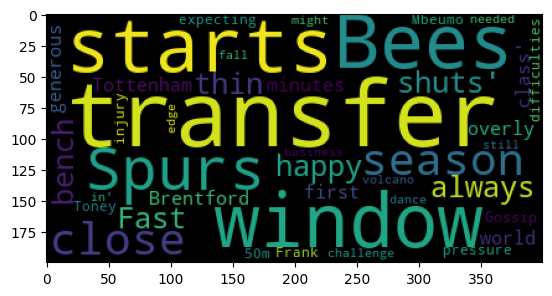

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = df_fact_title \
    .filter(pl.col("fk_team_id") == 4)

corpus = ' '.join(text['article_title'].to_list())

wc = WordCloud().generate(corpus)
plt.imshow(wc)

In [103]:
text

content
str
"""As Bournemouth reflect on the …"
"""Bournemouth assistant coach To…"
"""Earlier, we asked you for the …"
"""Sources say the deal to take D…"
"""Bournemouth manager Andoni Ira…"
"""Chris Sutton is making predict…"
"""Bournemouth have agreed a seas…"
"""Buried in Tuesday’s announceme…"
"""Bournemouth boss Andoni Iraola…"
